In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 8.8MB/s 
     |████████████████████████████████| 1.1MB 19.6MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
     |████████████████████████████████| 194kB 47.4MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
Mounted at /content/gdrive


In [2]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

#Convolutional Neural Networks in Depth
Wir blicken hinter die Kulissen von Convolutions.

In [3]:
top_edge = tensor([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]]).float()

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path

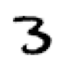

In [5]:
im3 = Image.open(path/'train'/'3'/'12.png')
show_image(im3);

In [6]:
im3_t = tensor(im3)
im3_t[0:3,0:3] * top_edge

tensor([[-0., -0., -0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [7]:
(im3_t[0:3,0:3] * top_edge).sum()

tensor(0.)

In [8]:
df = pd.DataFrame(im3_t[:10,:20])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


In [9]:
(im3_t[4:7,6:9] * top_edge).sum()

tensor(762.)

In [10]:
(im3_t[7:10,17:20] * top_edge).sum()

tensor(-29.)

In [11]:
top_edge

tensor([[-1., -1., -1.],
        [ 0.,  0.,  0.],
        [ 1.,  1.,  1.]])

In [12]:
def apply_kernel(row, col, kernel):
    return (im3_t[row-1:row+2,col-1:col+2] * kernel).sum()

In [13]:
apply_kernel(5,7,top_edge)

tensor(762.)

## Anwendung unseres Kernels

In [14]:
[[(i,j) for j in range(1,5)] for i in range(1,5)]

[[(1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 1), (4, 2), (4, 3), (4, 4)]]

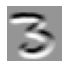

In [15]:
rng = range(1,27)
top_edge3 = tensor([[apply_kernel(i,j,top_edge) for j in rng] for i in rng])

show_image(top_edge3);

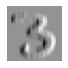

In [16]:
left_edge = tensor([[-1,1,0],
                    [-1,1,0],
                    [-1,1,0]]).float()

left_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])

show_image(left_edge3);

## Convolutions in PyTorch
`F.conv2d`

In [17]:
help(F.conv2d)

Help on built-in function conv2d:

conv2d(...)
    conv2d(input, weight, bias=None, stride=1, padding=0, dilation=1, groups=1) -> Tensor
    
    Applies a 2D convolution over an input image composed of several input
    planes.
    
    This operator supports :ref:`TensorFloat32<tf32_on_ampere>`.
    
    See :class:`~torch.nn.Conv2d` for details and output shape.
    
    Note:
        In some circumstances when using the CUDA backend with CuDNN, this operator
        may select a nondeterministic algorithm to increase performance. If this is
        undesirable, you can try to make the operation deterministic (potentially at
        a performance cost) by setting ``torch.backends.cudnn.deterministic =
        True``.
        Please see the notes on :doc:`/notes/randomness` for background.
    
    
    Args:
        input: input tensor of shape :math:`(\text{minibatch} , \text{in\_channels} , iH , iW)`
        weight: filters of shape :math:`(\text{out\_channels} , \frac{\text{in\_c

Warum benötigen wir einen Tensor mit Rang 4? Unsere Pixelmatrix hat ja nur 2 Dimensionen?!

1. PyTorch kann eine Convolution auf mehere Bilder parallel anwenden.
1. PyTorch kann mehrere Kernels parallel anwenden

--> Auf diese Weise kann ein Batch gleichzeitig bearbeitet werden.

In [18]:
diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()
diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()

edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])
edge_kernels.shape

torch.Size([4, 3, 3])

In [19]:
mnist = DataBlock((ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=GrandparentSplitter(),
                  get_y=parent_label)

dls = mnist.dataloaders(path)
xb,yb = first(dls.valid)
xb.shape

(64, 1, 28, 28)

In [20]:
xb,yb = to_cpu(xb),to_cpu(yb)

Die Funktion `F.conv2d` erwartet einen Tensor mit Rang 4: `[channels_in, features_out, rows, columns]`. Unser Kernel Tensor hat aktuell nur einen Rang von 3. Daher müssen wir eine zusätzliche Dimension einfügen.

In [21]:
edge_kernels.shape,edge_kernels.unsqueeze(1).shape

(torch.Size([4, 3, 3]), torch.Size([4, 1, 3, 3]))

In [22]:
edge_kernels = edge_kernels.unsqueeze(1)

In [23]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

(64, 4, 26, 26)

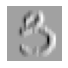

In [24]:
show_image(batch_features[0,0]);

## Strides und Padding

**Padding - no Stride:**
Wir verwenden einen Kernel der Größe `ks x ks`. Dafür benötigen wir Padding im Ausmaß von `ks//2` (für ks = ungerade)

![](https://upload.wikimedia.org/wikipedia/commons/0/06/Convolution_arithmetic_-_Full_padding_no_strides.gif)

**Padding - with Stride:**
Angenommen unser Bild hat die Größe `h x w` und wir verwenden `padding=1` und `stride=2`, dann erhalten wir ein Ergebnis in der Größe von `(n + 2*padding - ks) // stride`

![](https://upload.wikimedia.org/wikipedia/commons/2/2d/Convolution_arithmetic_-_Padding_strides_odd.gif)

**Die Mathematik hinter Padding und Stride**: https://medium.com/impactai/cnns-from-different-viewpoints-fab7f52d159c

## Wir bauen unser eigenes CNN auf

In [25]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [26]:
simple_net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [27]:
broken_cnn = sequential(
    nn.Conv2d(1,30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30,1, kernel_size=3, padding=1)
)

In [28]:
broken_cnn(xb).shape

(64, 1, 28, 28)

In [29]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [30]:
simple_cnn = sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,32),           #2x2
    conv(32,2, act=False), #1x1
    Flatten(),
    nn.Linear(2, 2)
)

In [31]:
simple_cnn(xb).shape

torch.Size([64, 2])

In [32]:
learn = Learner(dls, simple_cnn, metrics=accuracy)

In [33]:
learn.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                                        

In [34]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.142725,0.075529,0.975466,00:13
1,0.047722,0.063691,0.978410,00:12


## Arithmetik zu Convolutions

In [35]:
m = learn.model[0]
m

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)

In [36]:
m[0].weight.shape

torch.Size([4, 1, 3, 3])

In [37]:
m[0].bias.shape

torch.Size([4])

## Verarbeitung farbiger Bilder

In [38]:
im = image2tensor(Image.open(image_bear()))
im.shape

torch.Size([3, 1000, 846])

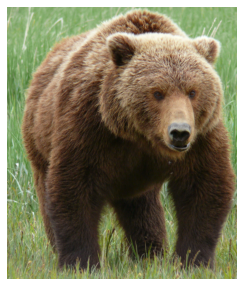

In [39]:
show_image(im);

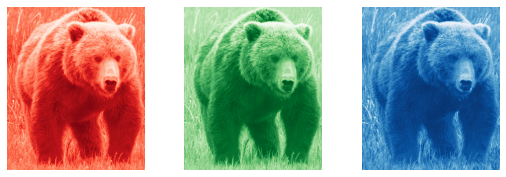

In [40]:
_,axs = subplots(1,3)
for bear,ax,color in zip(im,axs,('Reds','Greens','Blues')):
    show_image(255-bear, ax=ax, cmap=color)

Bislang haben wir Convolutions auf einem Filter für einen Channel (s/w Bilder) betrachtet.

![Bildquelle: fast.ai](https://raw.githubusercontent.com/fastai/fastbook/3916b71bdf2f9e587ac82f3c2ef4aabd05b8f51c/images/chapter9_rgbconv.svg)

Unser Kernel hat eine Größe `channels_in` von `3x3`. Wir addieren jeweils die Operationen unseres Kernels und summieren am Ende alle Kernel auf.

![Bildquelle: fast.ai](https://raw.githubusercontent.com/fastai/fastbook/3916b71bdf2f9e587ac82f3c2ef4aabd05b8f51c/images/chapter9_rgb_conv_stack.svg)

So erhalten wir dann einen Batch von Bildern mit `channels_out` Anzahl an Channels und Höhe sowie Breite entsprechend der vorherigen Berechnung: `ch_in x ks x ks`.

Zusätzlich hinzu kommt noch der Bias für jeden Filter: `Yr + Yg + Yb + b`.

## Optimieren des Trainingsprozesses unseres CNNs

In [41]:
path = untar_data(URLs.MNIST)

In [42]:
Path.BASE_PATH = path
path.ls()

(#2) [Path('testing'),Path('training')]

In [43]:
def get_dls(bs=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
        get_items=get_image_files, 
        splitter=GrandparentSplitter('training','testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=bs)

dls = get_dls()

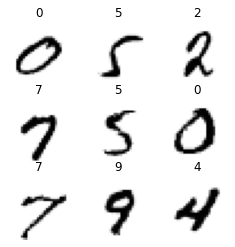

In [44]:
dls.show_batch(max_n=9, figsize=(4,4))

In [45]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [46]:
def simple_cnn():
    return sequential(
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        Flatten(),
        nn.Linear(10,10)
    )

In [47]:
from fastai.callback.hook import *

In [48]:
def fit(epochs=1):
    learn = Learner(dls, simple_cnn(),
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit(epochs, 0.06)
    return learn

In [49]:
learn.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                                        

In [50]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,2.308938,2.308303,0.113500,01:06


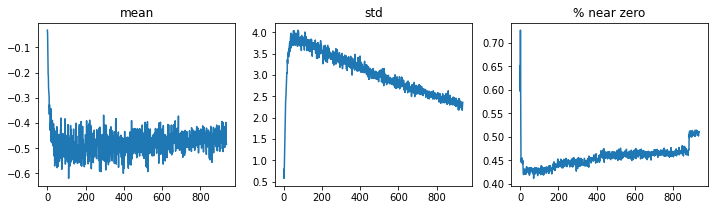

In [51]:
learn.activation_stats.plot_layer_stats(0)

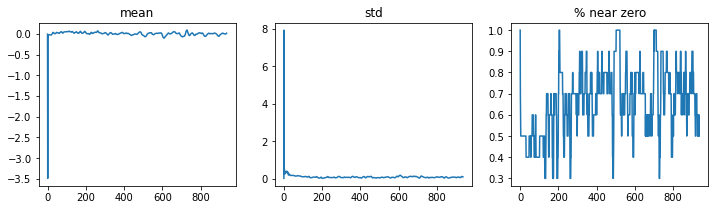

In [52]:
learn.activation_stats.plot_layer_stats(-2)

### Erhöhen der Batch-Size

In [53]:
dls = get_dls(512)

In [54]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,2.312514,2.303492,0.102800,00:53


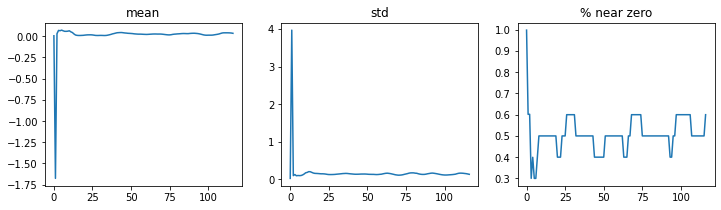

In [55]:
learn.activation_stats.plot_layer_stats(-2)

### 1 Cycle Training

In [56]:
def fit(epochs=1, lr=0.06):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)
    return learn

In [57]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.220497,0.081636,0.974900,00:52


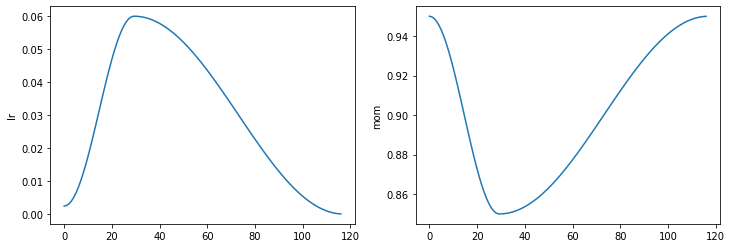

In [58]:
learn.recorder.plot_sched()

* `lr_max`
* `div`
* `div_final`
* `pct_start`
* `moms`

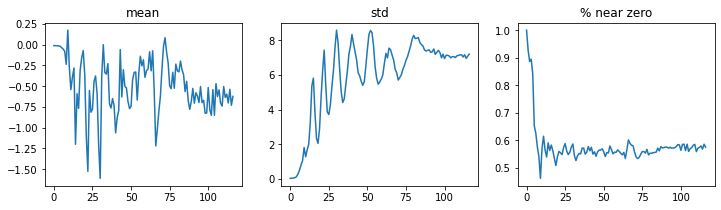

In [59]:
learn.activation_stats.plot_layer_stats(-2)

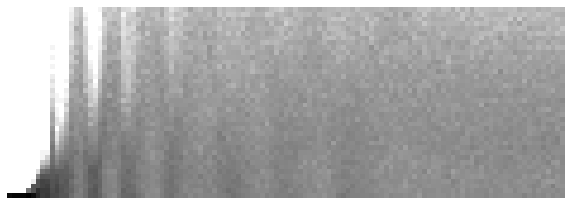

In [60]:
learn.activation_stats.color_dim(-2)

### Batch Normalization

In [61]:
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    layers.append(nn.BatchNorm2d(nf))
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [62]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.141383,0.050203,0.984500,00:55


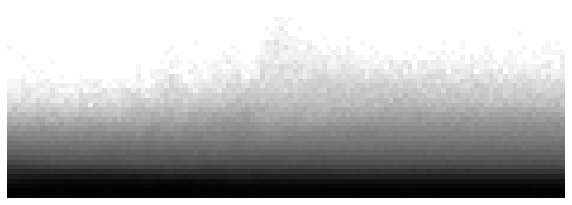

In [63]:
learn.activation_stats.color_dim(-4)

In [64]:
learn = fit(5, lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.199972,0.175270,0.952400,00:55
1,0.087588,0.052221,0.982200,00:54
2,0.054092,0.041694,0.986000,00:54
3,0.034115,0.027684,0.991300,00:54
4,0.016542,0.023107,0.991600,00:55
